In [1]:
from functions_py import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import pandas as pd 
# import cv2
import skimage as sk
import scipy.ndimage as nd
from array import array
from functions_MuonsNSAMP1 import *
import time

from ROOT import TProfile, TGraphErrors, TH2F

def gaussian(x, a, mean, sigma):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

# def Gaussian2(x,m1,s1,g1,a1, m2, s2, g2, a2): #data, mean, sigma, gain, height1, heigth2
#     return a1*np.exp(-1/2*((x-m1-g1)/s1)**2) + a2*np.exp(-1/2*((x-m2-g2)/s2)**2)

def Gaussian2(x,m,s,g,a1,a2): #data, mean, sigma, gain, height1, heigth2
    return a1*np.exp(-1/2*((x-m)/s)**2)+a2*np.exp(-1/2*((x-m-g)/s)**2)


def EnergySpectrum(x, N):
    return N * np.sin(x)*np.cos(x)**3

Colormap = 'jet'

# print(time.time())
# print(time.gmtime(0))

Welcome to JupyROOT 6.28/04


In [2]:
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth": 3,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})

Colormap = 'jet'

Filename: ../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_101.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   (700, 650)   float32   
  1                1 ImageHDU       164   (700, 650)   float32   
  2                1 ImageHDU       164   (700, 650)   float32   
  3                1 ImageHDU       164   (700, 650)   float32   
None
----------------


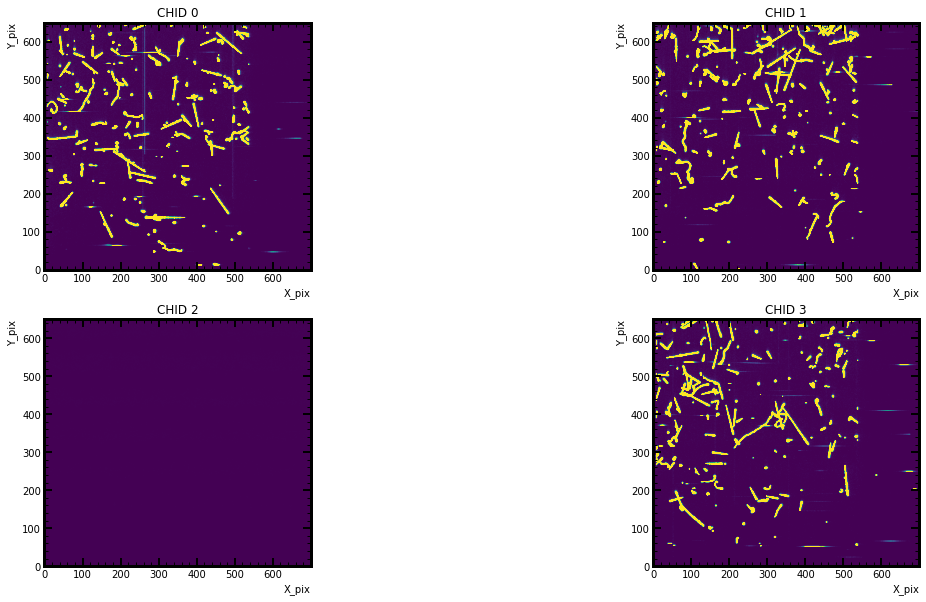

In [3]:
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/05JUN2023/proc_skp_m_009_microchip_vtested_T_170_seq_NSAMP_324_NROW_100_NCOL.fits'
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/17OCT23/am241_gammas/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_50_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_690.fits'
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/05JUN2023/proc_skp_m_009_microchip_vtested_T_170_seq_NSAMP_225_NROW_100_NCOL.fits'
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/05JUN2023/proc_skp_m_009_microchip_vtested_T_170_seq_NSAMP_144_NROW_100_NCOL.fits'
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/01NOV23/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_60_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_2.fits'
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/01NOV23/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_32.fits'


## DIRECCIONES DE COMPUTADORA DE CASA 
# path = '/home/bruce/Documents/imagenesMicrochip/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_25.fits'


# path = '/home/bruce/Documents/imagenesMicrochip/ENE24/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_62.fits'
# path = '/home/bruce/Documents/Programas/images/ENE2024/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_204.fits'

# path = '/home/bruce/Documents/Programas/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_100.fits'
# path = '/home/bruce/Documents/Programas/images/ENE2024/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_204.fits'


# path = '/home/labdet/Documents/MauSan/Programas/Repositorio_Git/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_100.fits'
# path = '/home/labdet/Documents/MauSan/Programas/Repositorio_Git/images/ENE2024/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_200.fits'

# path = '/home/bruce/Documents/Programas/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_100.fits'
# path = '/home/bruce/Documents/Programas/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_101.fits'
# path = '/home/bruce/Documents/Programas/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_102.fits'

path = '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_101.fits'



hdu_list = fits.open(path)
print(hdu_list.info())
print('----------------')
# hdu_list[0].header
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(hdu_list[i].data-np.median(hdu_list[i].data),vmin=0,vmax=10000, cmap = 'viridis')
    plt.title('CHID '+str(i))
    plt.ylabel('Y_pix')
    plt.xlabel('X_pix')
plt.show()

# Sustrayendo el promedio por renglón

## Sustrayendo la media del renglon

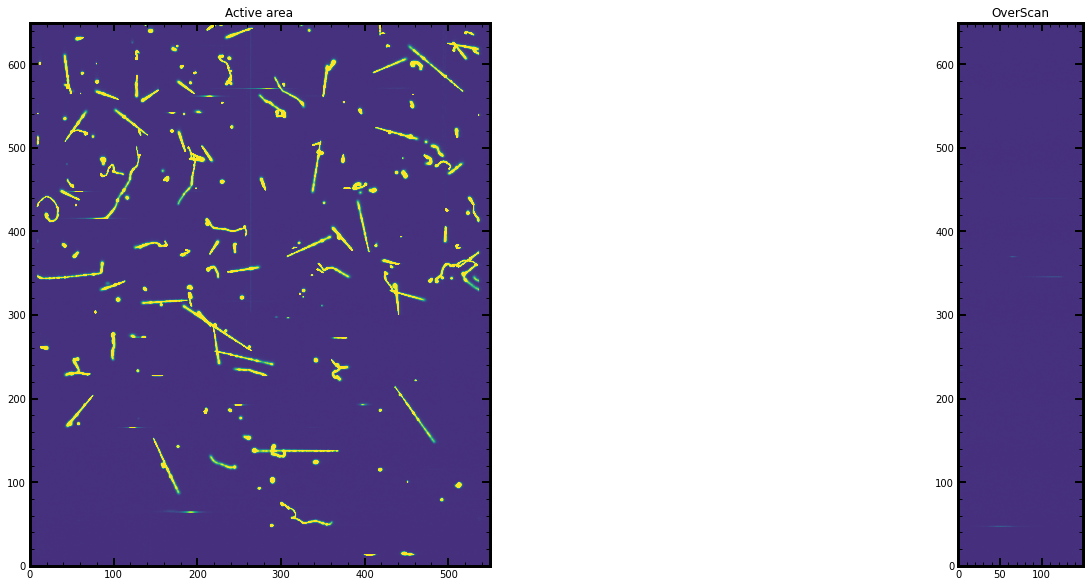

In [83]:
### Muestra el area activa y overscan de la extensión 

extension = 1
# plt.imshow(hdu_list[0].data[:, 550:], vmin = 0, vmax = 80000, origin = 'lower')
Overscan = hdu_list[extension - 1].data[:, 550:]
active_area = hdu_list[extension - 1].data[:, :550]


fig, axs = plt.subplots(1,2, figsize=[25,10])
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
axs[0].imshow(active_area, origin='lower', vmin = 1000, vmax = 100000)
axs[0].set_title('Active area')

axs[1].imshow(Overscan, origin='lower', vmin = 1000, vmax = 100000)
axs[1].set_title('OverScan')

# plt.colorbar()
plt.show()

# fig, axs = plt.subplots(figsize=[10,10])
# active_area_mask=sk.measure.label(active_area>=np.max(active_area), connectivity=2)
# active_area_true=ma.masked_array(active_area,mask=(active_area_mask>0))
# plt.colorbar(location = 'bottom')
# plt.colorbar()

# fig.colorbar(x1, ax=axs[0])
# fig.colorbar(x2, ax=axs[1])

plt.show()


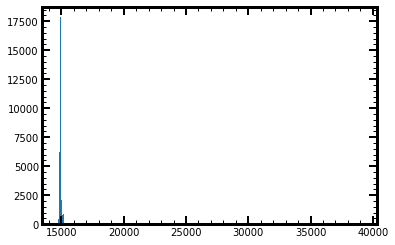

In [84]:
plt.hist(Overscan.flatten(), bins = 1000)
# plt.yscale('log')
plt.show()

In [85]:
### Dimensiones de Overscan
print('Dimensiones Oscan: ', Overscan.shape)
oscan_x = Overscan.shape[1]
oscan_y = Overscan.shape[0]


### Dimensiones de Active Area
print('Dimensiones ActA: ', active_area.shape)
acta_x = active_area.shape[1]
acta_y = active_area.shape[0]

Dimensiones Oscan:  (650, 150)
Dimensiones ActA:  (650, 550)


In [86]:
### Se sustrae la mediana de cada renglón y se crea un arreglo
medi_rows_value = []
for element in np.arange(0, oscan_y):
    row = Overscan[element: element +1, 0: oscan_x]
    num_row = element + 1
    # plt.imshow(row, origin='lower')
    # plt.show()
    # print(row.shape)
    # print(type(row))
    # print(row.sum()/row.shape[1])
    medi_value = np.median(row)
    medi_rows_value.append([medi_value])
    # print((num_row, mean_value))

print(medi_rows_value[0])

[14813.6455]


In [87]:
### Se le resta el valor de promedio de cada renglón a su respectivo renglon del area activa
true_active_area = active_area - medi_rows_value
print(active_area[1][1])
print(true_active_area[1][1])
### Se le resta el valor de promedio de cada renglón a su respectivo renglon del oScan
# true_Oscan = Overscan - mean_rows_value


true_Oscan = Overscan
min_oScan = np.min(true_Oscan)
# plt.imshow(true_active_area, origin='lower')

14791.263
-30.000977


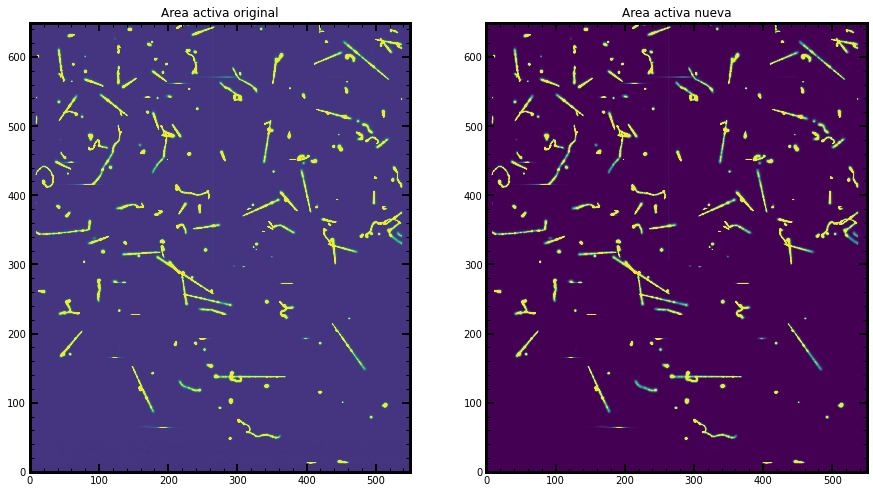

In [88]:
## Se muestra la comparación de la extensión original y despues de quitarle la mediana

Figsize = [15,15]
fig, axs = plt.subplots(1, 2, figsize=Figsize)
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
Vmin = 10
Vmax = 100000
axs[0].set_title('Area activa original')
axs[1].set_title('Area activa nueva')
x0 = axs[0].imshow(active_area, origin='lower', vmin=Vmin, vmax = Vmax)
x1 = axs[1].imshow(true_active_area, origin='lower', vmin=Vmin, vmax = Vmax)
# plt.colorbar()

# fig.colorbar(x0, ax=axs[0]) 
# fig.colorbar(x1, ax=axs[1])

# print(active_area.max())
# print(true_active_area.max())
plt.show()

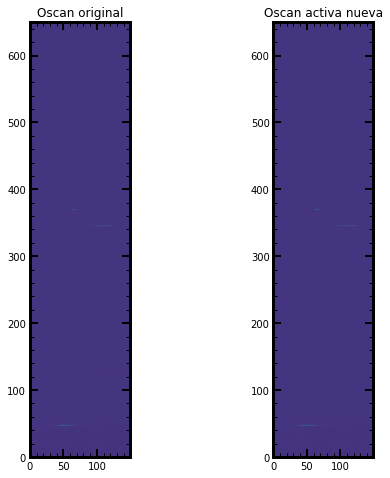

In [89]:
fig, axs = plt.subplots(1, 2, figsize=[8,8])
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
Vmin = 10
Vmax = 100000
axs[0].set_title('Oscan original')
axs[1].set_title('Oscan activa nueva')
x0 = axs[0].imshow(Overscan, origin='lower', vmin=Vmin, vmax = Vmax)
x1 = axs[1].imshow(true_Oscan, origin='lower', vmin=Vmin, vmax = Vmax)
# plt.colorbar()

# fig.colorbar(x0, ax=axs[0]) 
# fig.colorbar(x1, ax=axs[1])

# print(active_area.max())
# print(true_active_area.max())
plt.show()

[[14845.157  14827.639  14822.269  ... 14874.771  14834.633  14805.537 ]
 [14794.12   14814.827  14835.673  ... 14824.296  14771.197  15025.333 ]
 [14829.457  14767.194  14861.08   ... 14827.833  14846.367  14872.976 ]
 ...
 [15150.673  14943.296  14863.269  ... 14890.469  14895.901  15233.33  ]
 [15259.429  14940.244  14973.1045 ... 14966.34   14946.784  14879.858 ]
 [15003.809  14980.123  14943.667  ... 14959.024  14995.053  14961.164 ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


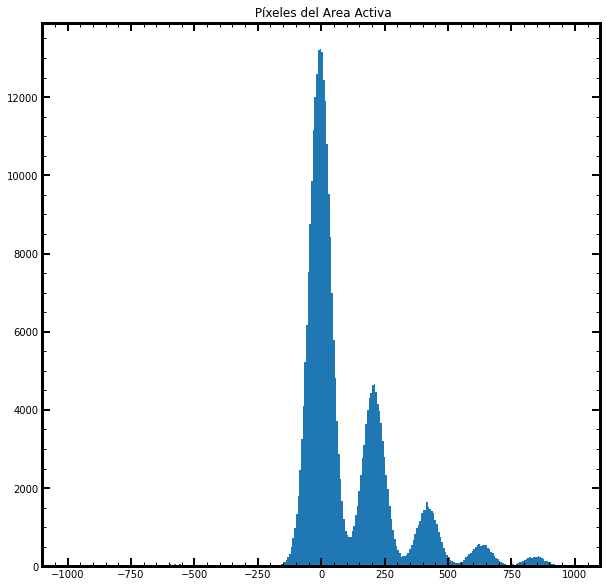

In [90]:
fig_all, axs_all = plt.subplots(1, 1, figsize=(10, 10))

print(true_Oscan)
min_oScan = np.min(true_Oscan)

# act = true_active_area - offset
## Generamos el histograma de los pixeles del oScan especificando el rango
axs_all.hist(true_active_area.flatten(), bins= 300, range = (-1000, 1000))# , label="Pixeles del Overscan")
# axs_all.hist(active_area.flatten(), bins= 300, range = (-1000, 1000))# , label="Pixeles del Overscan")
# axs_all.hist(true_Oscan.flatten(), bins= 200, range = (8000, 9500))# , label="Pixeles del Overscan")


# axs_all.vlines(14651.275, ymin=0, ymax=900, colors='k', linestyle = 'dashed', label = 'Offset')
# axs_all.vlines(14720.0, ymin=0, ymax=2000, colors='r')

axs_all.set_title(' Píxeles del Area Activa')
plt.legend()

plt.show()

## Aplanando el Oscan

### Doble Gaussiana

Offset Value:  14918.279  ADUs
Parameters of the Doble-Gaussian Fit
Mean:  5.656160795806672  +-  0.25994846632786706
Sigma:  46.52166447187044  +-  0.18641530476658436
Gain:  214.2518464926202  +-  0.7733317440200906
First Peak:  502.9213066900157  +-  2.1552075168639453
Second Peak:  30.36864500020598  +-  0.45798133861336693 

chiSquare: 658.7961002976226
NDegrees of Freedom: 580
Prob: 0.01268508902633002 

 FCN=658.796 FROM MIGRAD    STATUS=CONVERGED     139 CALLS         140 TOTAL
                     EDM=1.93686e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.65616e+00   2.59948e-01   2.47467e-03  -5.04273e-04
   2  p1           4.65217e+01   1.86415e-01   1.51615e-03  -2.21882e-03
   3  p2           2.14252e+02   7.73332e-01   9.08221e-03  -4.50035e-04
   4  p3           5.02921e+02   2.15521e+00   2.26631e-02  -2.012

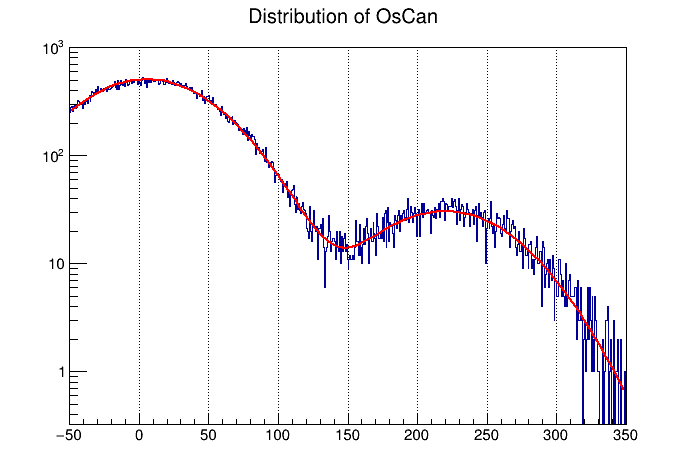

In [91]:
# min_oScan = np.min(true_Oscan)
# extension = 4
Bins = 600
Bins_fit = Bins
# Range_fit = [-100, 400]

Range_fit = [-50, 350]
ratio_keV = 0.0037  ## KeV/e-

# data = hdu_list[extension-1].data[:, :550]
data = true_active_area
header = hdu_list[extension-1].header
# oScan=hdu_list[extension-1].data[:,550:]

hist , bins_edges = np.histogram(true_Oscan.flatten(), bins = Bins,  range=(min_oScan, 18000))
offset = bins_edges[np.argmax(hist)]
print('Offset Value: ', offset, ' ADUs')
Overscan_plane = true_Oscan - offset 
fgaus2 = TF1("fgaus2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)

h3=TH1F("histogram", "Distribution of OsCan",Bins_fit,Range_fit[0],Range_fit[1])
h3.AddDirectory(False)
for pixel_value in Overscan_plane.flatten():
    # if not np.ma.is_masked(pixel_value):
    h3.Fill(pixel_value)
    #print(pixel_value)

fgaus2.SetParameters(0,40,210, 400, 50) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
# fgaus2.SetParameters(3.999255762274112,62.819921446387646, 197.8901791750652, 106.11699858208667, 4.973093664397046)

h3.Fit(fgaus2, "R")


c1=TCanvas()
c1.SetLogy()
h3.SetStats(0)
h3.Draw()
fgaus2.Draw("same")
c1.Draw()

gStyle.SetOptFit(1100)
gStyle.SetPadGridX (True)

# # fgaus2.Draw('Quiet')
print('Parameters of the Doble-Gaussian Fit')
print('Mean: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
print('Sigma: ', fgaus2.GetParameters()[1],  ' +- ', fgaus2.GetParError(1))
print('Gain: ', fgaus2.GetParameters()[2],  ' +- ', fgaus2.GetParError(2))
print('First Peak: ', fgaus2.GetParameters()[3],  ' +- ', fgaus2.GetParError(3))
print('Second Peak: ', fgaus2.GetParameters()[4],  ' +- ', fgaus2.GetParError(4), '\n')
print("chiSquare: " + str(fgaus2.GetChisquare()))
print("NDegrees of Freedom: " + str(fgaus2.GetNDF()))
# print("chiSquare / NDF :", fgaus2.GetChisquare() / fgaus2.GetNDF())
print("Prob:", fgaus2.GetProb(), '\n')


In [92]:
delta_Bin = 0
dict_popt =  oScan_fit_NSAMP324_ROOT(extensión = extension, active_area = data, oScan = true_Oscan, Bins = Bins+delta_Bin, Bins_fit=Bins_fit+delta_Bin,
                                        make_figure_flag = False, range_fit=[-30, 350])


 FCN=626.908 FROM MIGRAD    STATUS=CONVERGED     420 CALLS         421 TOTAL
                     EDM=1.32497e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.8 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.55922e+00   3.67647e-01  -3.63717e-04  -2.08028e-04
   2  p1           4.60279e+01   2.25504e-01   3.14548e-05  -5.50226e-04
   3  p2           2.13049e+02   8.15805e-01   3.43772e-04  -2.17703e-04
   4  p3           4.76692e+02   2.10983e+00   2.16751e-03  -3.10758e-05
   5  p4           2.89842e+01   4.44070e-01  -2.51977e-04  -3.29730e-04


In [93]:
##### Sigma en e- ####
sig_ADUs = dict_popt['sigma']
Gain = dict_popt['Gain']
offset = dict_popt['Offset']

sig_elec = abs(( sig_ADUs) / Gain)
sig_KeV = sig_elec * ratio_keV
print('Gain: ', Gain, ' ADUs/e-')
print('Sigma: ', sig_ADUs, ' ADUs, ', sig_elec, ' e-, ' , sig_KeV, ' KeV')

Gain:  213.0493209201817  ADUs/e-
Sigma:  46.027897678554794  ADUs,  0.21604339070293965  e-,  0.0007993605456008767  KeV


Sigma:  0.0007993605456008767  keV


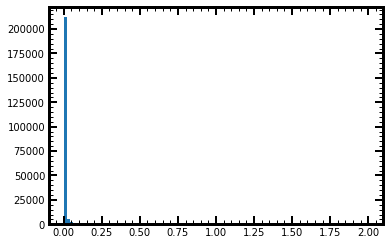

In [94]:
dataCal, sigma = data_calibrated_NSAMP(active_area = data, extension = extension, offset = offset, gain = Gain, ratio_keV = ratio_keV, unidades = 2, sigma_ADUs = sig_ADUs)
print('Sigma: ', sigma, ' keV')

plt.hist(dataCal.flatten(), bins = 100, range = (0, 2))
plt.show()

### Gauss-Poisson

In [421]:
def gauss_comppoisson_fit1(x, par):
    k = 1000
    #  m = 4
    #  ydata = 0;
    xval = x[0]
    a     = par[0]
    mu    = par[1]
    sigma = par[2]
    lambda_poisson = par[3]
    pgeom = par[4]
    gain  = par[5]
    # p=1
    fitval = 0.0
    for p in np.arange(0, k):
        fitval = fitval + a * TMath.Gaus(xval*gain,p-mu,sigma,1) * TMath.PoissonI(p,lambda_poisson)

    return fitval

Offset Value:  14910.084  ADUs
Realizando el ajuste
Offset fit:  0.0  +-  0.0  ADUs
Sigma fit:  60.0  +-  0.0  ADUs
Lambda fit:  2.0  +-  0.0
Gain fit:  200.0  +-  200.0  e-/ADUs 


Chiq:  0.0
Ndegf:  0
Prob:  0.0


Warning in <TROOT::Append>: Replacing existing TH1: histo (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv


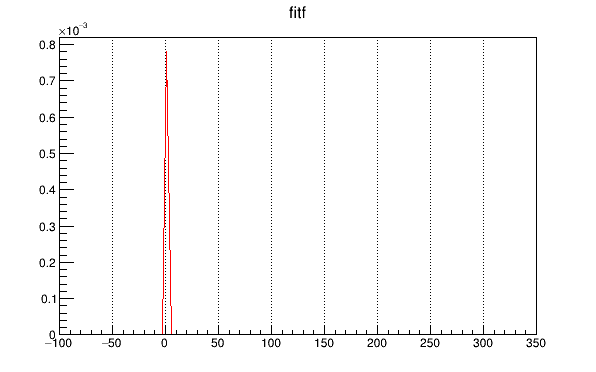

In [426]:
Bins = 1000
ratio_keV = 0.0037  ## KeV/e-

# data = hdu_list[extension-1].data[:, :550]
data = true_active_area
header = hdu_list[extension-1].header
# oScan=hdu_list[extension-1].data[:,550:]

hist , bins_edges = np.histogram(true_Oscan.flatten(), bins = Bins,  range=(min_oScan, 18000))
offset = bins_edges[np.argmax(hist)]
print('Offset Value: ', offset, ' ADUs')
Overscan_plane = true_Oscan - offset

# print(len(Overscan_plane))
# plt.hist(Overscan_plane.flatten(), bins = Bins, range=[-200, 500])

# fit_gausCONVcomppois(Overscan_plane)
data = Overscan_plane.flatten() ## get oScan data and turn 1D array
long_data = len(data)
# print('Ndata: ', long_data)
# print(data)

# print('Voy  a crear y llenar el hist')

histo = TH1F("histo","", Bins, -200, 500)
histo.GetXaxis().SetTitle("charge (e^{-})")

for pixel_value in data:
    # if not np.ma.is_masked(pixel_value):
    histo.Fill(pixel_value)
    # for ibin in np.arange(0, NBins):
    #     histo.SetBinContent(ibin,BinCont[ibin])

    # nevents = histo.Integral()
# print('N_events: ', nevents)
# print('Terminé de llenar todo, ahora haré el ajuste')

npar = 6        # nparameters
norm = 600   
offs = 0    # offset
sigm = 60    # sigma
lamb = 1  # lambda de Poisson
pgeo = 0    # probabilidad (se ignora en el cálculo)
gain = 200

lofit = -100
hifit =  350

fitf = TF1("fitf",gauss_comppoisson_fit1,lofit,hifit,npar)
fitf.SetParameter(0,norm)
fitf.SetParameter(1,offs)
fitf.SetParameter(2,sigm)
fitf.SetParameter(3,lamb)
fitf.SetParameter(4,pgeo)
fitf.SetParameter(5,gain)

# fitf.SetNpx(400)
# fitf.SetMinimum(1e-3)
fitf.SetLineWidth(1)

print('Realizando el ajuste')
# histo.Fit(fitf)
norm = fitf.GetParameter(0)
offs = fitf.GetParameter(1)
sigm = fitf.GetParameter(2)
lamb = fitf.GetParameter(3)
pgeo = fitf.GetParameter(4)
gain = fitf.GetParameter(5)

norme = fitf.GetParError(0)
offse = fitf.GetParError(1)
sigme = fitf.GetParError(2)
lambe = fitf.GetParError(3)
pgeoe = fitf.GetParError(4)
gaine = fitf.GetParError(5)

chisq = fitf.GetChisquare()
ndegf = fitf.GetNDF()
proba = fitf.GetProb()

canv = TCanvas("canv","",600,400)
#histo.Draw()
fitf.Draw("")

canv.Draw()

dict_info = {'par' : {'Offset':offs, 'Sigma':sigm, 'Gain':gain}, 'err' :  {'Offset':offse, 'Sigma':sigme, 'Gain':gaine},
                'fit_quality': {'Chiq' : chisq, 'Ndegf' : ndegf, 'Prob': proba}}

# print(dict_info)
print('Offset fit: ', offs, ' +- ', offse, ' ADUs')
print('Sigma fit: ', sigm, ' +- ', sigme, ' ADUs')
print('Lambda fit: ', lamb, ' +- ', lambe)
print('Gain fit: ', gain, ' +- ', gain, ' e-/ADUs \n\n' )

print('Chiq: ', chisq)
print('Ndegf: ', ndegf)
print('Prob: ', proba)



## Creacción del DataFrame de los clusters detectados

In [183]:
# min_energy_for_label = 100 * sigma
min_energy_for_label = 10 * sigma
label_img, nlabels_img = sk.measure.label(dataCal > min_energy_for_label, connectivity=2, return_num=True)
prop = sk.measure.regionprops(label_img, dataCal)

TotalDataFrame = event_DataFrame(dataCal=dataCal, label_img=label_img, nlabels_img =nlabels_img, 
                                    prop=prop, header=header, extension=extension, unidades = 2)

TotalDataFrame[0:20]

Events: 7063


,Image ID,Extension,Matrix Size (px),Event Size (px),Total Charge (KeV),Mean Charge (KeV),Barycenter (px)
Event ID,,,,,,,
1,101,1,1x1,1,0.011425,0.011,"[0.0, 0.0]"
2,101,1,1x1,1,0.009799,0.010,"[0.0, 0.0]"
3,101,1,1x1,1,0.008888,0.009,"[0.0, 0.0]"
4,101,1,3x1,3,0.031308,0.010,"[1.0, 0.0]"
5,101,1,21x1,21,241.940338,11.521,"[10.0, 0.0]"
6,101,1,1x1,1,0.010328,0.010,"[0.0, 0.0]"
7,101,1,26x6,106,265.946564,2.509,"[11.0, 1.9811]"
8,101,1,2x2,2,0.016399,0.008,"[0.5, 0.5]"
9,101,1,1x1,1,0.016514,0.017,"[0.0, 0.0]"


[[False False  True False False]
 [False  True  True  True False]
 [ True  True  True  True  True]
 [False  True  True  True False]
 [False False  True False False]]


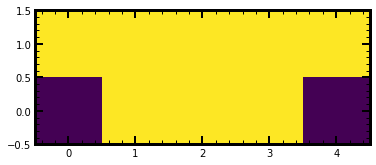

In [184]:
list_example = [[0,0,0,0,0], [0,0,0,0,0], [0,0, True,0,0], [0,0,0,0,0], [0,0,0,0,0]]
skirt = nd.binary_dilation(list_example, iterations=2)
print(skirt)

plt.imshow(skirt[1:3, :])

## Visualizar un cluster y su información

3
Event Slice:
x: [8,11]
y: [12,13]


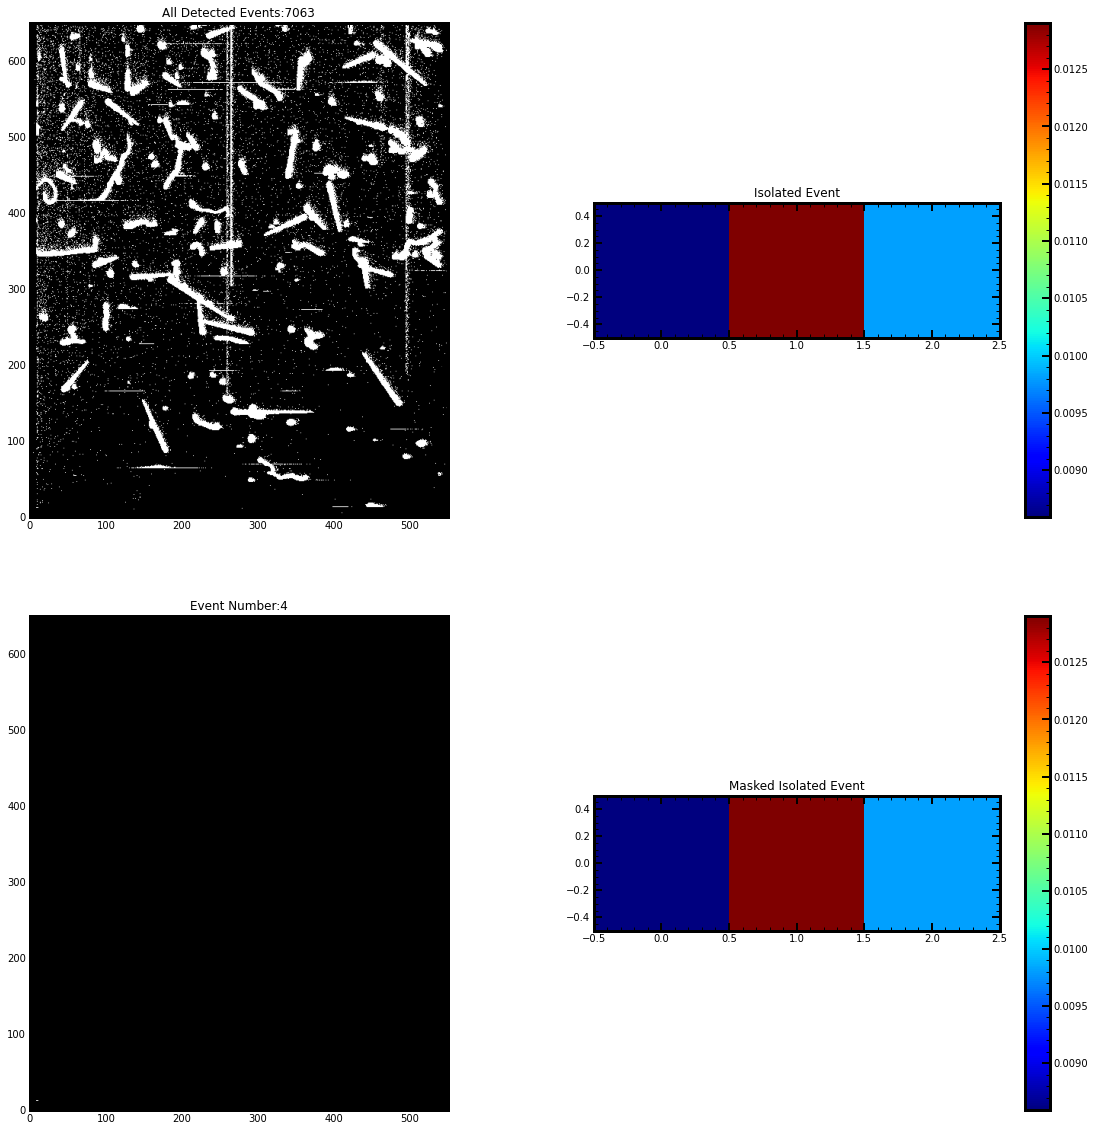

,Image ID,Extension,Matrix Size (px),Event Size (px),Total Charge (KeV),Mean Charge (KeV),Barycenter (px)
Event ID,,,,,,,
4,101,1,3x1,3,0.031308,0.01,"[1.0, 0.0]"


In [185]:
n_label = 4
extra = 0


label, n_events = ndimage.label(dataCal > min_energy_for_label,structure=[[1,1,1],[1,1,1],[1,1,1]]) # 48
# label, n_events = ndimage.label(dataCal>6*abs(popt[2]),structure=[[0,1,0],[1,1,1],[0,1,0]]) ## 50, 52
loc = ndimage.find_objects(label==n_label)[0]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=[20,20])
# fig.subplots_adjust(left=0.1, bottom=0.1, right=0.5, top=0.9)
# fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)

# fig.suptitle('Event Number '+ str(n_label))
## Imagen original
axs[0,0].set_title('All Detected Events:'+str(n_events))
axs[0,0].imshow(label==0, cmap='gist_yarg', vmax=1, vmin=0, origin='lower')
# plt.suptitle('Primer Imagen')

## Evento en la imagen original
axs[1,0].set_title('Event Number:'+str(n_label))
axs[1,0].imshow(label==n_label, cmap='gray', vmax=1,vmin=0, origin='lower')


axs[0,1].set_title('Isolated Event')
x1 = axs[0,1].imshow(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], cmap= Colormap)#, origin = 'lower')
# plt.colorbar()

mask_35 = np.invert(label==n_label)


data_mask = ma.masked_array(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], mask_35[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra])
print(len(data_mask[0]))

axs[1,1].set_title('Masked Isolated Event')
x2 = axs[1,1].imshow(data_mask, cmap= Colormap)#, origin='lower')
# axs[1,1].plot(totalFrame.iat[n_label-1, 7][0], totalFrame.iat[n_label-1, 7][1], 'ro') ## Plot the baricentrum
# print('n_label:', n_label)
# plt.legend('Baricentrum')

fig.colorbar(x1, ax=axs[0,1])
fig.colorbar(x2, ax=axs[1,1])
# fig.colorbar(axs[1,1], ax=[[x1,x2]], location = 'bottom', fraction = .1)

print('Event Slice:'  )
print('x: ['+str(loc[1].start)+','+str(loc[1].stop)+']')
print('y: ['+str(loc[0].start)+','+str(loc[0].stop)+']')
# print(loc)
# print(totalFrame.set_index('Event ID').iloc[[n_label-1]])
plt.show()


TotalDataFrame.iloc[[n_label-1]]

### Con faldas

5
Event Slice:
x: [9,10]
y: [45,46]


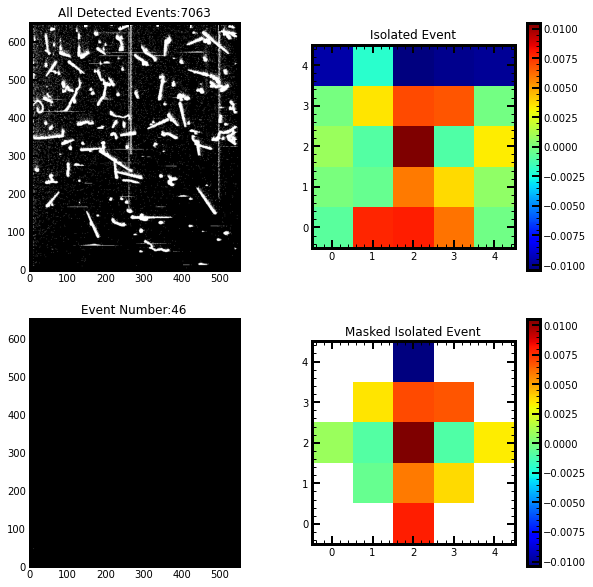

,Image ID,Extension,Matrix Size (px),Event Size (px),Total Charge (KeV),Mean Charge (KeV),Barycenter (px)
Event ID,,,,,,,
46,101,1,1x1,1,0.010513,0.011,"[0.0, 0.0]"


In [186]:
n_label = 46
n_skirts = 2
extra = 2


label, n_events = ndimage.label(dataCal > min_energy_for_label,structure=[[1,1,1],[1,1,1],[1,1,1]]) # 48
# label, n_events = ndimage.label(dataCal>6*abs(popt[2]),structure=[[0,1,0],[1,1,1],[0,1,0]]) ## 50, 52
loc = ndimage.find_objects(label==n_label)[0]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=[10,10])
# fig.subplots_adjust(left=0.1, bottom=0.1, right=0.5, top=0.9)
# fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)

# fig.suptitle('Event Number '+ str(n_label))
## Imagen original
axs[0,0].set_title('All Detected Events:'+str(n_events))
axs[0,0].imshow(label==0, cmap='gist_yarg', vmax=1, vmin=0, origin='lower')
# plt.suptitle('Primer Imagen')

## Evento en la imagen original
axs[1,0].set_title('Event Number:'+str(n_label))
axs[1,0].imshow(label==n_label, cmap='gray', vmax=1,vmin=0, origin='lower')


axs[0,1].set_title('Isolated Event')
x1 = axs[0,1].imshow(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], cmap= Colormap)#, origin = 'lower')
# plt.colorbar()

### Skirts ###
mask_35 = np.invert(nd.binary_dilation(label==n_label, iterations= n_skirts))
# mask_35 = np.invert(label==n_label)
# skirt = nd.binary_dilation(mask_35, structure=[[0,0,0],[0,1,0],[0,0,0]], iterations = 2)
# print(skirt)


data_mask = ma.masked_array(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], mask_35[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra])
print(len(data_mask[0]))

axs[1,1].set_title('Masked Isolated Event')
x2 = axs[1,1].imshow(data_mask, cmap= Colormap)#, origin='lower')
# axs[1,1].plot(totalFrame.iat[n_label-1, 7][0], totalFrame.iat[n_label-1, 7][1], 'ro') ## Plot the baricentrum
# print('n_label:', n_label)
# plt.legend('Baricentrum')

fig.colorbar(x1, ax=axs[0,1])
fig.colorbar(x2, ax=axs[1,1])
# fig.colorbar(axs[1,1], ax=[[x1,x2]], location = 'bottom', fraction = .1)

print('Event Slice:'  )
print('x: ['+str(loc[1].start)+','+str(loc[1].stop)+']')
print('y: ['+str(loc[0].start)+','+str(loc[0].stop)+']')
# print(loc)
# print(totalFrame.set_index('Event ID').iloc[[n_label-1]])
plt.show()


TotalDataFrame.iloc[[n_label-1]]

## Pruebas de la paquetería Sckit-Image

Centroide:  (11.0, 278.0)
Radio mayor:  0.0
Radio menor:  0.0
Box:  (11, 278, 12, 279)
Centroid Weighted:  (11.0, 278.0)
Label:  3
Orientation:  -0.7853981633974483
Slice:  (slice(11, 12, None), slice(278, 279, None))
Eccentricity:  0
Solidity:  1.0
Barycenter:  [0. 0.]


Event Charge:  0.008888327  keV
Local Box:  [1, 1]  px
Local Box:  [15, 15] micras
Diagonal Lenght:  0.0  px
Diagonal Lenght:  0.0  micras
Delta_L:  725.0  px
Delta_L:  10875.0  micras
Delta EL:  1.2259760807300436e-05  keV/px
Delta EL:  8.173173871533624e-07  keV/micras
Delta EL:  0.12259760807300435  keV/cm


(277.0, 280.0, 10.0, 13.0)

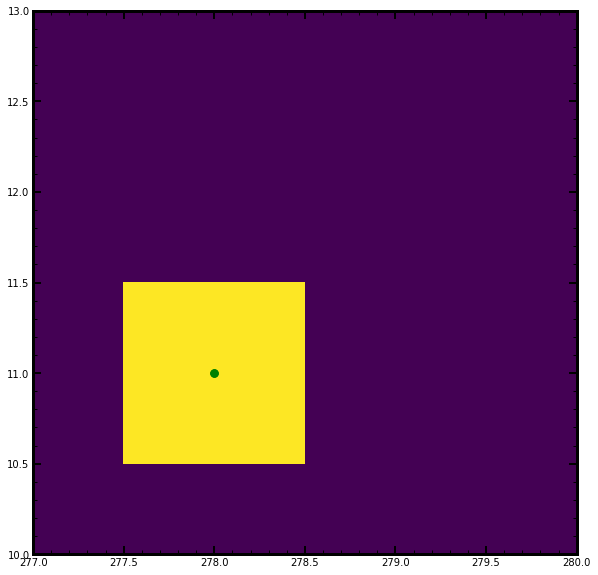

In [187]:
### Esta celda tiene el proceso para ir obteniendo las propiedadesd de un evento con la librería Scikit-Image

n_label= 3
CCD_depth = 725 ## micras
px_to_micras = 15 ## micras
px_to_cm = 0.0015 ## cm/px
micra_to_cm = 1 / 10000 ## micras/cm
fig, ax = plt.subplots(figsize=(10,10))

label_img, nlabels_img = sk.measure.label(dataCal > min_energy_for_label, connectivity=2, return_num=True)
# print(nlabels_img)
ax.imshow(label_img==n_label) # Matriz centrada en el origen

prop = sk.measure.regionprops(label_img,dataCal)
# prop = sk.measure.regionprops(label_img)


# loc = ndimage.find_objects(label==n_label)[0]
loc = prop[n_label-1].slice

mask_35 = np.invert(label_img==n_label)
# ax.imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
charge = data_mask.sum()
# plt.imshow(dataCal[maxim.start:maxim.stop])
# ax.imshow(data_mask)



print("Centroide: ", prop[n_label-1].centroid)
print("Radio mayor: ", prop[n_label-1].axis_major_length)
print("Radio menor: ", prop[n_label-1].axis_minor_length)
print("Box: ", prop[n_label-1].bbox)
# print("Centroide Local: ", prop[n_label-1].centroid_local)
print('Centroid Weighted: ', prop[n_label-1].centroid_weighted)
# print(prop[n_label-1].centroid_weighted_local)
# print(prop[n_label-1].coords_scaled)
# print(prop[n_label-1].coords)
# print(prop[n_label-1].extent)
# print(prop[n_label-1].image)
# print(prop[n_label-1].image_intensity)
print('Label: ', prop[n_label-1].label)
print('Orientation: ', prop[n_label-1].orientation)
print('Slice: ', prop[n_label-1].slice)
print('Eccentricity: ', prop[n_label-1].eccentricity)
print('Solidity: ', prop[n_label-1].solidity)
print('Barycenter: ', prop[n_label-1].centroid_local)
# print('Inertia tensor: ', prop[n_label-1].inertia_tensor)
# print('Intensity Max: ', prop[n_label-1].intensity_max)

print('\n')
## Ellipse 
y0, x0 = prop[n_label-1].centroid
# y0, x0 = prop[n_label-1].centroid_weighted

orientation = prop[n_label-1].orientation
rotation = orientation*1
x1 = x0 + math.cos(orientation) * 0.5 * prop[n_label-1].axis_minor_length
y1 = y0 - math.sin(orientation) * 0.5 * prop[n_label-1].axis_minor_length

x2 = x0 - math.sin(orientation) * 0.5 * prop[n_label-1].axis_major_length
y2 = y0 - math.cos(orientation) * 0.5 * prop[n_label-1].axis_major_length # Ellipse's major radio

x3 = x0 - math.sin(-orientation) * 0.5 * prop[n_label-1].axis_major_length
y3 = y0 + math.cos(orientation) * 0.5 * prop[n_label-1].axis_major_length # Ellipse's major radio


ax.plot((x0, x1), (y0, y1), 'r', linewidth=1)
ax.plot((x0, x3), (y0, y3), 'b', linewidth=1)
ax.plot((x0, x2), (y0, y2), 'r', linewidth=1)

ax.plot(x0, y0, '.g', markersize=15) # Ellipse's center
ax.plot(prop[n_label-1].centroid_weighted[1], prop[n_label-1].centroid_weighted[0], '.g', markersize=15)

## Box and Delta_L
miny, minx, maxy, maxx = prop[n_label-1].bbox
Longitud_y = maxy - miny # px
Longitud_x = maxx - minx # px
Diagonal_lenght= np.sqrt(Longitud_x**2 + Longitud_y**2) - np.sqrt(2) # px
Delta_L = np.sqrt(Diagonal_lenght**2 + CCD_depth**2) # px
DeltaEL = charge / Delta_L # keV/px

print('Event Charge: ', charge, ' keV')
print("Local Box: ", [Longitud_x, Longitud_y], ' px' )
print("Local Box: ", [Longitud_x * px_to_micras, Longitud_y * px_to_micras], 'micras' )
print('Diagonal Lenght: ', Diagonal_lenght, ' px') ## px
print('Diagonal Lenght: ', Diagonal_lenght * px_to_micras, ' micras')
print('Delta_L: ', Delta_L, ' px')
print('Delta_L: ', Delta_L * px_to_micras, ' micras')
print('Delta EL: ', DeltaEL, ' keV/px')
print('Delta EL: ', DeltaEL / px_to_micras, ' keV/micras')
print('Delta EL: ', DeltaEL / micra_to_cm, ' keV/cm')
bx = (minx, maxx, maxx, minx, minx)
by = (miny, miny, maxy, maxy, miny)
# ax.plot(bx, by, '-b', linewidth=2.5)


# excent = prop[n_label-1].eccentricity
u= x0   #x-position of the center
v= y0    #y-position of the center
b = prop[n_label-1].axis_major_length    #radius on the x-axis
a = prop[n_label-1].axis_minor_length   #radius on the y-axis

ext=1
ax.axis((loc[1].start-ext, loc[1].stop+ext, loc[0].start-ext, loc[0].stop+ext))
# ax.imshow(data_mask)
# ax.can_zoom()

## Filtro de muones 

In [188]:
## Calcula cuantos eventos rectos tiene la extensión comparando la relación del radio mayor de la elipse con el radio menor
DeltaL, DeltaEL, list_charge, lebel_muons, list_theta, list_phi, _ = muon_filter(dataCal=dataCal, label_img=label_img, nlabels_img=nlabels_img, 
                                                                                 prop=prop, Solidit=0.7, Elipticity=0.65)
                                                                    
print('All Clusters: ', nlabels_img)
print('Muons Detected: ', len(lebel_muons))
print(lebel_muons)
Straight_Events = lebel_muons


DF_straightevents = pd.DataFrame(lebel_muons, columns=['Event ID'] )
DF_dl = pd.DataFrame(DeltaL, columns=['Delta L (cm)'])
DF_charge = pd.DataFrame(list_charge, columns=['Charge (e-)'])
DF_dedl = pd.DataFrame(DeltaEL, columns=['dE/dL (e-/cm)'])
DF_thet = pd.DataFrame(list_theta, columns=['Theta (Rad)'])
DF_phi = pd.DataFrame(list_phi, columns=['Phi (Rad)'])
DF_dEdL = pd.concat([DF_straightevents, DF_dl, DF_charge,  DF_dedl, DF_thet, DF_phi], axis=1)
DF_dEdL.set_index('Event ID')

All Clusters:  7063
Muons Detected:  4
[7, 728, 6856, 6991]


,Delta L (cm),Charge (e-),dE/dL (e-/cm),Theta (Rad),Phi (Rad)
Event ID,,,,,
7,0.081810,265.946564,3250.767964,0.481728,3.026716
728,0.081144,18.496819,227.949945,0.465781,0.119429
6856,0.084294,342.356812,4061.440311,0.535369,0.374334
6991,0.075526,76.251312,1009.600993,0.284037,6.150634



****************************************
Minimizer is Minuit / Migrad
Chi2                      =      6.12286
NDf                       =           24
Edm                       =   3.2672e-22
NCalls                    =           32
p0                        =      1.72635   +/-   0.192532    
p1                        =   -0.0631292   +/-   0.0132076   

****************************************
Minimizer is Minuit / Migrad
Chi2                      =       4.1032
NDf                       =           23
Edm                       =  3.38208e-23
NCalls                    =           32
p0                        =      1.28786   +/-   0.164004    
p1                        =    0.0256849   +/-   0.0117145   

****************************************
Minimizer is Minuit / Migrad
Chi2                      =      3.44435
NDf                       =            9
Edm                       =  5.38152e-23
NCalls                    =           32
p0                        =     0.137843   +/- 

In [189]:
index_event = 6 # 0, 1, 4, 8
loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
mask_35 = np.invert(label_img == Straight_Events[index_event])
data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
plt.imshow(data_mask)

IndexError: list index out of range

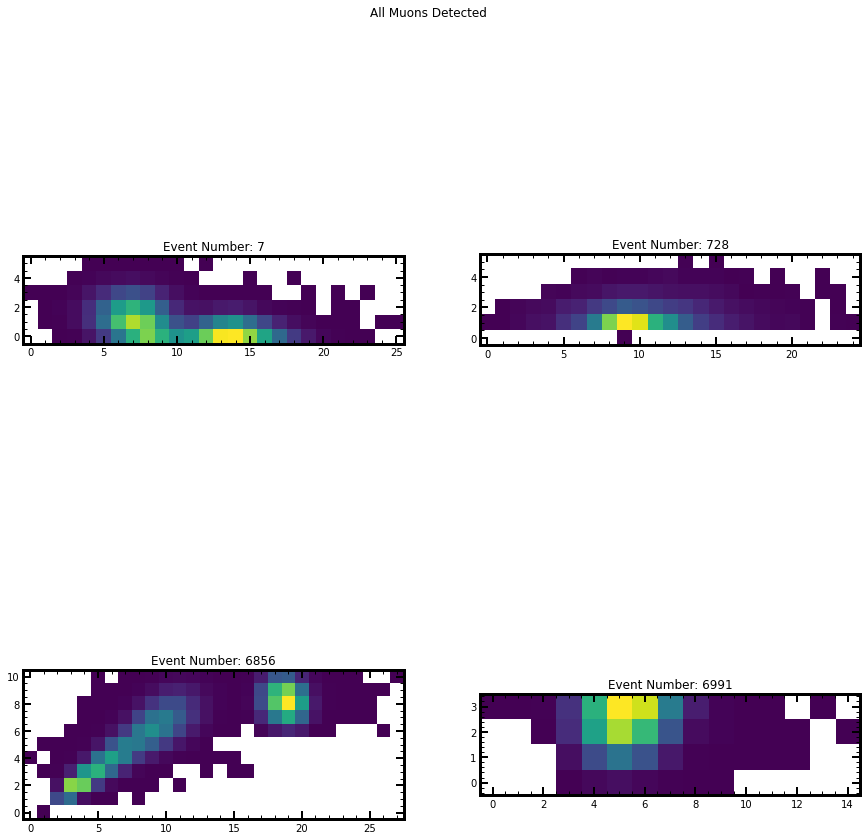

In [190]:
## Visualizar en una matriz los eventos rectos detectados 
coord2x2 = [[0,0],[0,1], [1,0], [1,1]]

coord3x3 = [[0,0],[0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]

coord4x4 = [[0,0],[0,1], [0,2], [0,3], [1,0], [1,1], [1,2], [1,3], [2,0], [2,1], [2,2], [2,3], [3,0], [3,1], [3,2], [3,3]]

coords5x5 = [[0,0],[0,1], [0,2], [0,3], [0,4], [1,0], [1,1], [1,2], [1,3], [1,4], [2,0], [2,1], [2,2], [2,3], [2,4], [3,0], [3,1], [3,2], [3,3], [3,4],[4,0], [4,1], [4,2], [4,3], [4,4]]

if len(Straight_Events) < 5:
    fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize=(15,15))
    fig.suptitle('All Muons Detected')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
        # plt.imshow(dataCal[maxim.start:maxim.stop])
        # ax.imshow(data_mask)

        axs[coord2x2[index_event][0],coord2x2[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        # axs[coord2x2[index_event][0],coord2x2[index_event][1]].imshow(label_img == Straight_Events[index_event]) ## All image
        # axs[coord2x2[index_event][0],coord2x2[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coord2x2[index_event][0],coord2x2[index_event][1]].imshow(data_mask) ## Event with mask
        # axs[coord2x2[index_event][0],coord2x2[index_event][1]].plot(TF.iat[Straight_Events[index_event]-1, 9][0], TF.iat[Straight_Events[index_event]-1, 9][1],  'ro')#[0], TF.iat[index_

elif len(Straight_Events) > 4 and len(Straight_Events) < 10:
    fig, axs = plt.subplots(ncols = 3, nrows = 3, figsize=(15,15), facecolor = [0, 0.4470, 0.7410])
    fig.suptitle('All Straight Events Detected')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
        # plt.imshow(dataCal[maxim.start:maxim.stop])
        # ax.imshow(data_mask)

        axs[coord3x3[index_event][0],coord3x3[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        # axs[coord3x3[index_event][0],coord3x3[index_event][1]].imshow(label_img == Straight_Events[index_event]) ## All image
        # axs[coord3x3[index_event][0],coord3x3[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coord3x3[index_event][0],coord3x3[index_event][1]].imshow(data_mask, aspect = 1,  cmap= Colormap) ## Event with mask
        # axs[coord3x3[index_event][0],coord3x3[index_event][1]].plot(TF.iat[Straight_Events[index_event]-1, 9][0], TF.iat[Straight_Events[index_event]-1, 9][1],  'ro')#[0], TF.iat[index_event, 7][1], 'ro') ## Plot the baricentrum

elif len(Straight_Events) > 9 and len(Straight_Events) < 17:
    fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize=(15,15), facecolor = [0, 0.4470, 0.7410])
    fig.suptitle('All Straight Events Detected')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

        # coordX_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[1])
        # coordY_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[0])
        # Barycentercharge = data_maskEvent[coordY_centerCharge, coordX_centerCharge]

        axs[coord4x4[index_event][0],coord4x4[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].imshow(label_img == Straight_Events[index_event]) ## All image
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coord4x4[index_event][0],coord4x4[index_event][1]].imshow(data_mask, aspect = 1, cmap = Colormap) ## Event with mask
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].plot(TF.iat[Straight_Events[index_event]-1, 9][0], TF.iat[Straight_Events[index_event]-1, 9][1],  'ro')#[0], TF.iat[index_
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].text(1,0,'dE/dx', transform = axs[coord4x4[index_event][0],coord4x4[index_event][1]].transAxes)

elif len(Straight_Events) > 16 and len(Straight_Events) <= 25:
    fig, axs = plt.subplots(ncols = 5, nrows = 5, figsize=(15,15), facecolor = [0, 0.4470, 0.7410])
    fig.suptitle('All Straight Events Detected')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
        # plt.imshow(dataCal[maxim.start:maxim.stop])
        # ax.imshow(data_mask)        

        axs[coords5x5[index_event][0],coords5x5[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        # axs[coords5x5[index_event][0],coords5x5[index_event][1]].imshow(label_img == Straight_Events[index_event])
        # axs[coords5x5[index_event][0],coords5x5[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coords5x5[index_event][0],coords5x5[index_event][1]].imshow(data_mask, aspect = 1, cmap = Colormap) ## Event with mask

elif len(Straight_Events) > 25:
    print('Demasiados eventos para mostrar!!!')



### All CLusters

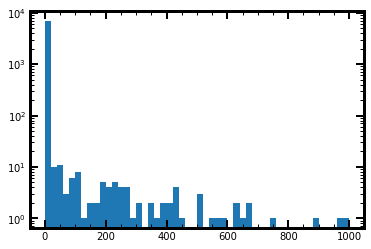

In [193]:
list_charge = all_cluster(dataCal=dataCal, label_img=label_img, nlabels_img=n_events, prop=prop)

plt.hist(list_charge, bins = 50, range = (0, 1000))
# plt.ylim(0, 20)
plt.yscale('log')
plt.show()

## Medición el ángulo phi

### Renglones y columnas

La longitud del renglon es:  22
La longitud de la columna es:  27
El renglon de abajo tiene:  5  elementos no vacíos.
El renglon de arriba tiene:  2  elementos no vacíos.
La cola está arriba 

La columna de la izquierda tiene:  3  elementos no vacíos.
La columna de la derecha tiene:  6  elementos no vacíos.
La cola está a la izquierda


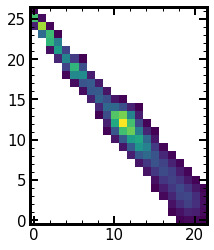

In [405]:
index_event = 3 # 6
loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
mask_35 = np.invert(label_img == Straight_Events[index_event])
data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
plt.imshow(data_mask)
# prop[event-1]
# print(data_mask.max)

len_y, len_x = data_mask.shape
flag_u, flag_d, flag_l, flag_r = False, False, False, False

n_up = 0
n_down = 0
row_down = data_mask[2]
row_up = data_mask[-2]

print('La longitud del renglon es: ', len_x)
print('La longitud de la columna es: ', len_y)
## Se cuentan los elementos que son distintos de cero
for element in row_up:
    if element != 0:
        n_up = n_up + 1
for element in row_down:
    if element != 0:
        n_down = n_down + 1

print('El renglon de abajo tiene: ', n_down, ' elementos no vacíos.')
print('El renglon de arriba tiene: ', n_up, ' elementos no vacíos.')
# print(len_x - n_up)
# print(len_x - n_down)
if n_down < n_up:
    flag_d = True
    print('La cola está abajo \n')
else:
    flag_u = True
    print('La cola está arriba \n')

n_left = 0
n_right = 0

col_left = data_mask[:,1]
col_right = data_mask[:,-2]
for element in col_left:
    if element != 0:
        n_left = n_left + 1
for element in col_right:
    if element != 0:
        n_right = n_right + 1
print('La columna de la izquierda tiene: ', n_left, ' elementos no vacíos.')
print('La columna de la derecha tiene: ', n_right, ' elementos no vacíos.')

# print(len_y - n_left)
# print(len_y - n_right)
if n_left < n_right:
    flag_l = True
    print('La cola está a la izquierda')
else: 
    flag_r = True
    print('La cola está a la derecha')


# print(len(data_mask[:,5]))
# print(data_mask[5])

In [406]:
# print(flag_u)
if len_x < 7:
    len_x = len_x / 2
    if flag_d and flag_l: # Cuadrante I
        phi = np.arctan(len_y/len_x) # En radianes

    elif flag_d and flag_r: # Cuadrante II
        phi_comp = np.arctan(len_x/len_y)
        # print(phi_comp)
        phi = phi_comp + np.pi/2

    elif flag_u and flag_r: # Cuadrante III
        phi_comp = np.arctan(len_y/len_x) 
        phi = phi_comp + np.pi

    elif flag_u and flag_l: # Cuadrante IV
        phi_comp = np.arctan(len_x/len_y)
        phi = phi_comp + 3 * np.pi/2

elif len_y < 7:
    len_y = len_y / 2
    if flag_d and flag_l: # Cuadrante I
        phi = np.arctan(len_y/len_x) # En radianes

    elif flag_d and flag_r: # Cuadrante II
        phi_comp = np.arctan(len_x/len_y)
        # print(phi_comp)
        phi = phi_comp + np.pi/2

    elif flag_u and flag_r: # Cuadrante III
        phi_comp = np.arctan(len_y/len_x) 
        phi = phi_comp + np.pi

    elif flag_u and flag_l: # Cuadrante IV
        phi_comp = np.arctan(len_x/len_y)
        phi = phi_comp + 3 * np.pi/2

else:
    if flag_d and flag_l: # Cuadrante I
        phi = np.arctan(len_y/len_x) # En radianes

    elif flag_d and flag_r: # Cuadrante II
        phi_comp = np.arctan(len_x/len_y)
        # print(phi_comp)
        phi = phi_comp + np.pi/2

    elif flag_u and flag_r: # Cuadrante III
        phi_comp = np.arctan(len_y/len_x) 
        phi = phi_comp + np.pi

    elif flag_u and flag_l: # Cuadrante IV
        phi_comp = np.arctan(len_x/len_y)
        phi = phi_comp + 3 * np.pi/2

print('El ángulo phi del muon es: ', np.degrees(phi))

El ángulo phi del muon es:  309.1736579704442


### Con sigmas X y Y

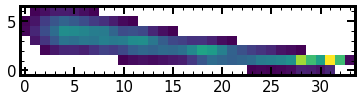

Shape of image (X, Y):  34 7
Len XProfile:  7
Len YProfile:  34


In [26]:
index_event = 1 #-4 # 0, 1, 4, 8
loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
mask_35 = np.invert(label_img == Straight_Events[index_event])
data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
plt.imshow(data_mask)
plt.show()

# print(data_mask)

NBX = data_mask.shape[1]
xmin = 0
xmax = NBX
# print(NBX, len(data_mask[:, 1]))

NBY = data_mask.shape[0]
ymin = 0
ymax = NBY
# print(NBY, len(data_mask[1, :]))
print('Shape of image (X, Y): ', NBX, NBY)


YProf = TProfile("YProf", "", NBX, 0, xmax)
XProf = TProfile("XProf", "", NBY, 0, ymax)

for i in np.arange(0, NBX):
    # print(i)
    for j in np.arange(0, NBY):
        # print(j)
        if data_mask[j][i]:
            XProf.Fill(j, i, data_mask[j][i])
            YProf.Fill(i, j, data_mask[j][i])


list_yprofile_mean = []
list_yprofile_sigma = []
for index in np.arange(0, NBX):
    mean_y = YProf.GetBinContent(int(index+1))
    sigma_y = YProf.GetBinError(int(index+1))

    list_yprofile_mean.append(mean_y)
    list_yprofile_sigma.append(sigma_y)
# print(list_yprofile_sigma)

list_xprofile_mean = []
list_xprofile_sigma = []
for index in np.arange(0, NBY):
    mean_x = XProf.GetBinContent(int(index+1))
    sigma_x = XProf.GetBinError(int(index+1))

    list_xprofile_mean.append(mean_x)
    list_xprofile_sigma.append(sigma_x)

print('Len XProfile: ', len(list_xprofile_mean))
print('Len YProfile: ', len(list_yprofile_mean))
# print(list_yprofile_mean)



In [23]:
print('YMEAN: ', list_yprofile_mean)
print('YSIG: ', list_yprofile_sigma)
print('XSIG: ', list_xprofile_mean)
print('XMEAN: ', list_xprofile_sigma)

YMEAN:  [4.178652872438259, 4.0670657294819454, 4.1185772412058705, 4.0127077245357174, 3.905130384135639, 3.8769633694620915, 3.7801698708303757, 3.564221448401461, 3.420478426034927, 3.310886115030272, 3.0709346602999372, 2.8913711912186773, 2.8116878050495493, 2.680920063975428, 2.4560454617653638, 2.2476129869603985, 2.1621453003175524, 1.9780285400476227, 1.8761795563590242, 1.747767458160212, 1.6326512965133582, 1.5222348540700603, 1.4341730893185145, 1.3458156110448034, 1.2352026588510834, 1.2026950577596924, 1.076608378906162, 1.006162349200917, 0.9078900277889447, 0.8919655647996705, 0.9127492952109547, 0.902840851115425, 1.0, 1.0]
YSIG:  [0.3219830777530864, 0.47032029571707945, 0.5045815565607864, 0.5296028328771476, 0.5267770629769604, 0.5287527944198783, 0.5090218786003601, 0.4969511268367661, 0.49211884887256585, 0.4823659897250567, 0.46255927774534566, 0.4613537243625685, 0.46501925053751625, 0.4507562743548765, 0.4425105301733142, 0.41892428048949865, 0.4168638617242809

Warning in <TCanvas::Constructor>: Deleting canvas with same name: C1


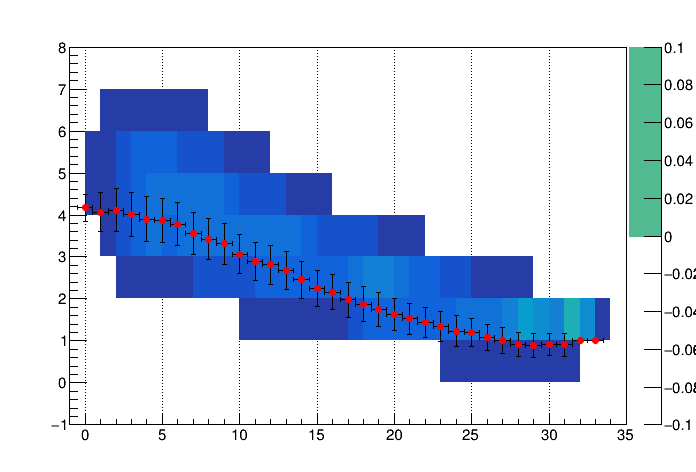

In [34]:
GRprofX = TGraphErrors()
GRprofY = TGraphErrors()

for i in np.arange(0, NBX):
    GRprofY.SetPoint(int(i), i, list_yprofile_mean[i])
    GRprofY.SetPointError(int(i), 1/2, list_yprofile_sigma[i])
    
for ip in np.arange(0, NBY):
    GRprofX.SetPoint(int(ip),  list_xprofile_mean[ip], ip)
    GRprofX.SetPointError(int(ip), list_xprofile_sigma[ip], 1/2)


canv = TCanvas("C1")
frame = TH2F("frame", "", 40,-1,NBX+1,40,-1,NBY+1)
frame.AddDirectory(False)
canv.Draw()
frame.Draw()

### -------------- Hist Muon ------------- ####
nbx = NBX
lox = 0
hix = data_mask.shape[1]

nby = NBY
loy = 0
hiy = data_mask.shape[0]

hist2d = TH2F("hist2d", "", nbx,lox,hix, nby,loy,hiy)
for i in np.arange(0, nbx):
    for j in np.arange(0, nby):
        # cont = data_mask[i][j]
        if data_mask[j][i]:
            hist2d.SetBinContent(int(i+1),int(j+1), data_mask[j][i])
        else:
            # n = n+1
            # print(n)
            cont = 0
            hist2d.SetBinContent(int(i+1),int(j+1), cont)

### ---------------------------------------- ###

frame = TH2F("frame", "", NBX+1,-1,NBX+1,NBY+1,-1,NBY+1)

canv.Draw()
frame.Draw()
frame.SetStats(0)
hist2d.Draw("samecolz")

GRprofX.SetMarkerStyle(20)
GRprofX.SetMarkerSize(0.8)
GRprofX.SetMarkerColor(5)
# GRprofX.Draw("P same")

GRprofY.SetMarkerStyle(20)
GRprofY.SetMarkerSize(0.8)
GRprofY.SetMarkerColor(2)
GRprofY.Draw("p same")

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.7992851601406188, 1.2935217894254891, 1.247780870706441, 1.1044564501481624, 0.9377156115805723, 0.7708264226195919, 0.6069798564825604]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


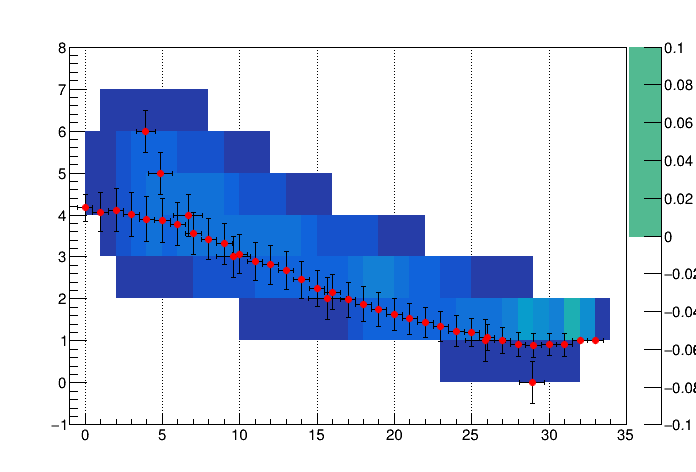

In [35]:
#### -------------------- MEAN XY ---------------- ###
list_x_XY = list(np.arange(0, NBX))
for element in list_xprofile_mean:
    list_x_XY.append(element)
# print(list_x_XY)

list_y_XY = list(list_yprofile_mean)
for element in np.arange(0, NBY):
    list_y_XY.append(element)
# print(list_y_XY)
### ----------------------------------------------- ###

#### -------------------- SIGMA XY ---------------- ###
zerosXY = list(np.zeros(NBX))
list_xsigma_XY = []
for index in np.arange(0, len(zerosXY)):
    list_xsigma_XY.append(1/2)
# print(list_xsigma_XY)

for element in list_xprofile_sigma:
    list_xsigma_XY.append(element)
print(list_xsigma_XY)

list_ysigma_XY = list(list_yprofile_sigma)
for element in list(np.zeros(NBY)):
    list_ysigma_XY.append(1/2)
# print(list_ysigma_XY)
### ----------------------------------------------- ###



# plt.plot(list_x, list_y, 'o')

GRprofXY = TGraphErrors()

for index in np.arange(0, len(list_y_XY)):
    GRprofXY.SetPoint(int(index), list_x_XY[index], list_y_XY[index])
    GRprofXY.SetPointError(int(index), list_xsigma_XY[index], list_ysigma_XY[index])

canv = TCanvas("c1")
frame = TH2F("frame", "", NBX+1,-1,NBX+1,NBY+1,-1,NBY+1)
frame.AddDirectory(False)
canv.Draw()
frame.Draw()
frame.SetStats(0)

hist2d.Draw("samecolz")

GRprofXY.SetMarkerStyle(20)
GRprofXY.SetMarkerSize(0.8)
GRprofXY.SetMarkerColor(2)
GRprofXY.Draw("P same")


Ordenada:  4.209601851078334
Pendiente:  -0.11568258056393477
Probabilidad:  0.9999999999999993


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      1.60946
NDf                       =           32
Edm                       =  5.12537e-23
NCalls                    =           31
p0                        =       4.2096   +/-   0.0752565   
p1                        =    -0.115683   +/-   0.00392035  


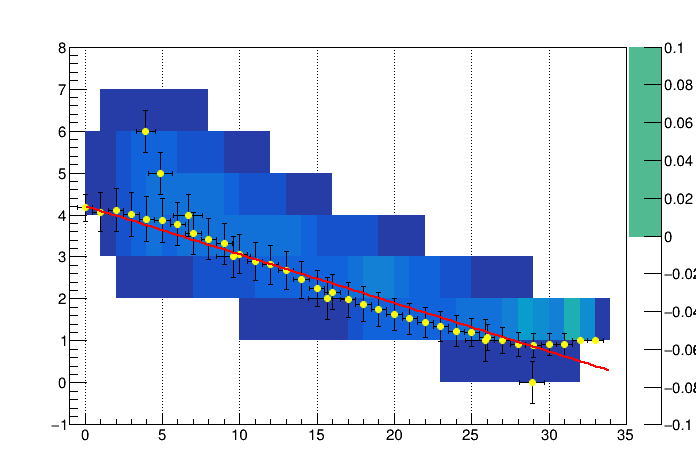

In [68]:
lox = 0
hix = NBX
fitline = TF1("fitline", "[0] + [1]*x",lox,hix) 

diag = np.sqrt(NBX**2 + NBY**2)
pend = NBY/NBX

fitline.SetParameters(NBY-1, -pend)
# fitline.SetParameters(0, pend)
# fitline.SetParameters(1, 1)
GRprofY.Fit("fitline", "W")  #### Funcionó aunque los paŕametros iniciales fueron malos
# GRprofY.Fit("fitline", "C")

ordenada = fitline.GetParameters()[0]
pendiente = fitline.GetParameters()[1]
Prob = fitline.GetProb()

print('Ordenada: ', ordenada)
print('Pendiente: ', pendiente)
print('Probabilidad: ', Prob, end='\n\n')

frame = TH2F("frame", "", NBX+1,-1,NBX+1,NBY+1,-1,NBY+1)
canv.Draw()
frame.Draw()
frame.SetStats(0)
hist2d.Draw("samecolz")

GRprofXY.SetMarkerStyle(20)
GRprofXY.SetMarkerSize(0.8)
GRprofXY.SetMarkerColor(5)
GRprofXY.Draw("P same")
fitline.Draw("same")

In [27]:
First = list_yprofile_sigma[5]
Last = list_yprofile_sigma[-5]
print(len(list_xprofile_sigma), First, Last)

if pendiente > 0:
    print('pendiente positiva')
    if First < Last: ## La "cola" está en la parte de abajo, y el muon está en el cuadrante 1
        phi = np.arctan(NBY/NBX)
        print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')
    else: ## La "cola" está en la parte de arriba, y el muon está en el cuadrante 3
        phi = np.arctan(NBY/NBX) + np.radians(180)
        print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')
else: 
    print('pendiente negativa')
    if First < Last: ## La "cola" está en la parte de arriba, y el muon está en el cuadrante 4
        phi = np.arctan(NBX/NBY) + np.radians(270)
        print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')
    else: ## La "cola" está en la parte de arriba, y el muon está en el cuadrante 4
        phi = np.arctan(NBX/NBY) + np.radians(90)
        print('El ángulo phi es: ', phi, ' rad o ' + str(np.degrees(phi)) + '°')
    

7 0.5287527944198783 0.27891099299012434
pendiente negativa
El ángulo phi es:  2.9385474363363278  rad o 168.36636600105956°


Muones detectados:  21
Shape (Y, X):  (14, 5)
El ángulo phi es: 1.9138202672156 o 109.6538240580533°


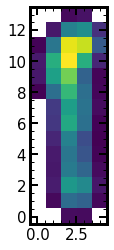


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      3.98829
NDf                       =            3
Edm                       =  2.06144e-22
NCalls                    =           29
p0                        =      8.73982   +/-   0.893117    
p1                        =    -0.185154   +/-   0.364614    


In [22]:
print('Muones detectados: ', len(Straight_Events))
index_event = 6 # En la imagen 100 funcionó con todos con phi_angle_ROOT()
                 #
loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
mask_35 = np.invert(label_img == Straight_Events[index_event])
data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
print( 'Shape (Y, X): ', data_mask.shape)
phi = phi_angle_ROOT(data_mask)
# try:
# phi = phi_angle_ROOT_pendpos(data_mask)
# except: 
# phi = phi_angle_ROOT_pendneg(data_mask)

print('El ángulo phi es: ' + str(phi) + ' o ' + str(np.degrees(phi))+ '°')
plt.imshow(data_mask)
plt.show()

### Suma de carga por cuadrantes

9.885864760159466
charge ld:  134.6283
charge rd:  1066.7523
charge ru:  731.1946
charge lu:  469.6898
La cola está abajo derecha


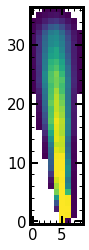

In [522]:
index_event = 4 # 0, 1, 4, 8
loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
mask_35 = np.invert(label_img == Straight_Events[index_event])
data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
plt.imshow(data_mask)
print(data_mask.mean())
len_y, len_x = data_mask.shape
flag_ld, flag_rd, flag_ru, flag_lu = False, False, False, False

left_down = data_mask[ 0:int(len_y/2), 0:int(len_x/2)]
right_down = data_mask[0:int(len_y/2), int(len_x/2):len_x]
right_up = data_mask[int(len_y/2):len_y, int(len_x/2):len_x]
left_up = data_mask[int(len_y/2):len_y, 0:int(len_x/2)]

down = data_mask[0:int(len_y/2), :]
up =  data_mask[int(len_y/2):len_y, :]
left = data_mask[:, 0:int(len_x/2)]
right = data_mask[:, int(len_x/2):len_x]

# plt.imshow(left_up)
# plt.imshow(left_down)

charge_d = down.sum()
charge_u = up.sum()
charge_l = left.sum()
charge_r = right.sum()

charge_ld = left_down.sum()
charge_rd = right_down.sum()
charge_ru = right_up.sum()
charge_lu = left_up.sum()
# print(charge_d, charge_u, charge_l, charge_r)
print('charge ld: ', charge_ld)
print('charge rd: ', charge_rd)
print('charge ru: ', charge_ru)
print('charge lu: ', charge_lu)



diff_deltas = 20
if charge_ld > charge_rd and charge_ld > charge_ru and charge_ld > charge_lu: 
    if charge_ld - charge_ru < diff_deltas:
        flag_ru = True
        print('La cola está arriba derecha (correccion)')
    else: 
        flag_ld = True
        print('La cola está abajo izquierda')
    
elif charge_rd > charge_ld and charge_rd > charge_ru and charge_rd > charge_lu:
    if charge_rd - charge_lu < diff_deltas:
        flag_lu = True
        print('La cola está arriba izquierda (correccion)')
    else:
        flag_rd = True
        print('La cola está abajo derecha')

elif charge_ru > charge_ld and charge_ru >charge_rd and charge_ru > charge_lu:
    if charge_ru - charge_ld < diff_deltas:
        flag_ld = True
        print('La cola está abajo izquierda (correccion)')
    else:
        flag_ru = True
        print('La cola está arriba derecha')

elif charge_lu > charge_ld and charge_lu > charge_rd and charge_lu > charge_ru:
    if charge_lu - charge_rd < diff_deltas:
        flag_rd = True
        print('La cola está abajo derecha (correccion)') 
    else:
        flag_lu = True
        print('La cola está arriba izquierda')

# print(flag_ru, flag_lu, flag_ld, flag_rd)

In [513]:
if len_x < 7:
    len_x = len_x  / 2
    if flag_ld: # Cuadrante I
        phi = np.arctan(len_y/len_x) # En radianes

    elif flag_rd: # Cuadrante II
        phi_comp = np.arctan(len_x/len_y)
        # print(phi_comp)
        phi = phi_comp + np.pi/2

    elif flag_ru: # Cuadrante III
        phi_comp = np.arctan(len_y/len_x) 
        phi = phi_comp + np.pi

    elif flag_lu: # Cuadrante IV
        phi_comp = np.arctan(len_x/len_y)
        phi = phi_comp + 3 * np.pi/2
        
elif len_y < 7:
    len_y = len_y  / 2
    if flag_ld: # Cuadrante I
        phi = np.arctan(len_y/len_x) # En radianes

    elif flag_rd: # Cuadrante II
        phi_comp = np.arctan(len_x/len_y)
        # print(phi_comp)
        phi = phi_comp + np.pi/2

    elif flag_ru: # Cuadrante III
        phi_comp = np.arctan(len_y/len_x) 
        phi = phi_comp + np.pi

    elif flag_lu: # Cuadrante IV
        phi_comp = np.arctan(len_x/len_y)
        phi = phi_comp + 3 * np.pi/2

else:
    if flag_ld: # Cuadrante I
        phi = np.arctan(len_y/len_x) # En radianes

    elif flag_rd: # Cuadrante II
        phi_comp = np.arctan(len_x/len_y)
        # print(phi_comp)
        phi = phi_comp + np.pi/2

    elif flag_ru: # Cuadrante III
        phi_comp = np.arctan(len_y/len_x) 
        phi = phi_comp + np.pi

    elif flag_lu: # Cuadrante IV
        phi_comp = np.arctan(len_x/len_y)
        phi = phi_comp + 3 * np.pi/2

print('El ángulo phi del muon es: ', np.degrees(phi))

El ángulo phi del muon es:  353.79655209830815


## Filtro de Muones Rectos

In [25]:
list_vertical, list_horizontal = muon_straight_filter(dataCal=dataCal, label_img=label_img, n_events=n_events, Solidit=0.7, Elipticity=0.7, 
                                                        Prop=prop, min_Charge=100, Sigma=sigma, skirts = 1)
# print(list_vertical[1])
print('Eventos Verticales encontrados: ', len(list_vertical[1]))
print('Eventos Verticales encontrados: ', len(list_horizontal[1]))
# plt.imshow(list_vertical[1][0])


Eventos Verticales encontrados:  3
Eventos Verticales encontrados:  0


Charge:  141.36455


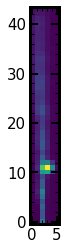

In [23]:
index = 0
plt.imshow(list_vertical[1][index])
print('Charge: ', list_vertical[2][index])


# plt.imshow(list_horizontal[1][0])
# print('Charge: ', list_horizontal[2][0])

## Perfil de Energía de un muon vertical

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1418.5356 318.92035


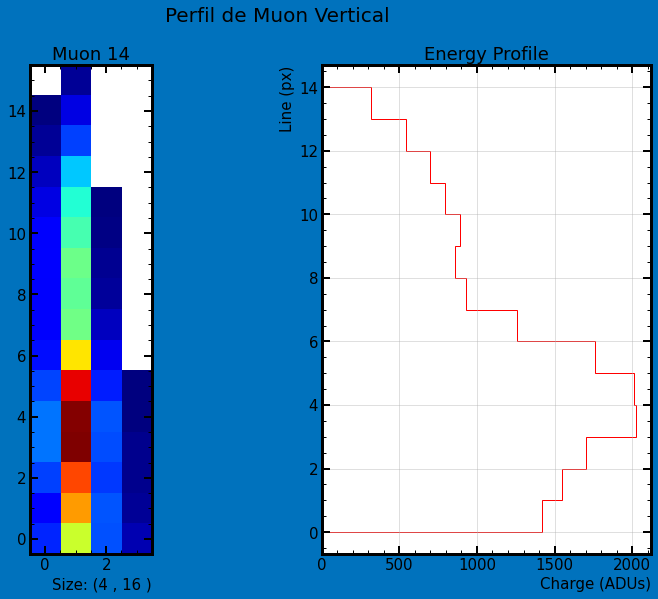

In [29]:
## Muons Extention 4
# muons_vertical_labels_1 = [[73], [3], [6], [14], [27]] #, 23,  27, 40, 43, 46, 49, 59, 85, 92, 94, 98] # Extensión 4

muon_label = 14  # Se coloca directamente el label del evento

Delta_inicial = 1
Delta_final = 1
# extension = 4

fig, axs = plt.subplots(ncols=2, nrows=1, figsize = [13,9], facecolor = [0, 0.4470, 0.7410])
fig.suptitle('Perfil de Muon Vertical', y = 0.97, size = 20)

# for event in matrix_ext_4_vertical[num:num + 1]:

# event = check_flip_vertical_muon(dict= data_histogram, label_muon=muon_label, Delta_in=Delta_inicial, Delta_fin=Delta_final, extension=extension)
loc = ndimage.find_objects(label==muon_label)[0]
mask_35 = np.invert(label==n_label)
data_mask = ma.masked_array(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], mask_35[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra])

muon_recto = data_mask
# print(muon_recto)


event = data_mask
# plt.imshow(event)
size_x = event.shape[1] # tamaño en x
size_y = event.shape[0] # tamaño en y
# print(event.sum())

label_verticalMuon, nlabels_verticalMuon = ndimage.label(event,structure=[[0,0,0],[1,1,1],[0,0,0]])

charge_verticalMuon = []
for lable_line in np.arange(Delta_inicial, nlabels_verticalMuon - Delta_final):
    line = label_verticalMuon == lable_line
    loc = ndimage.find_objects(label_verticalMuon == lable_line)[0]
    mask_35 = np.invert(label_verticalMuon == lable_line)
    data_mask = ma.masked_array(event[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
    # print(len(data_mask[0]))
    charge = data_mask.sum()
    # print(charge)
    mean_charge = data_mask.mean()

    charge_verticalMuon.append(charge)
    # print(charge)

## Linea inferior ##
# line_inf = [size_x]
# axs[0].imshow(data_mask)
print(charge_verticalMuon[0], charge_verticalMuon[-1])
        
# cmap = 'plasma'
axs[0].imshow(event, cmap = 'jet', origin='lower')
axs[0].set_title('Muon ' + str(muon_label))
axs[0].set_xlabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')
# x0bar = fig.colorbar(x0, ax=axs[0])

axs[1].stairs(charge_verticalMuon, np.arange(0,len(charge_verticalMuon)+1),  orientation='horizontal', color = 'r')#,  hatch = '////')
# axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))
axs[1].set_xlabel('Charge (ADUs)')
axs[1].set_ylabel('Line (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs[1].set_title('Energy Profile')
axs[1].legend()
axs[1].grid()
plt.show()

## Modelo de Difusión 

16
True


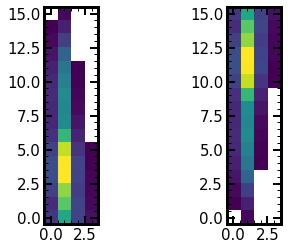

In [31]:
Delta_inicial = 1    # px
Delta_final = 1     # px


event = muon_recto
# plt.imshow(event)

label_verticalMuon, nlabels_verticalMuon = ndimage.label(event,structure=[[0,0,0],[1,1,1],[0,0,0]])
print(nlabels_verticalMuon)
### Parte de abajo de la imagen ##
line = label_verticalMuon == Delta_inicial
# print(Delta_inicial)

loc = ndimage.find_objects(label_verticalMuon == Delta_inicial)[0]
mask_35 = np.invert(label_verticalMuon == Delta_inicial)
data_mask = ma.masked_array(event[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

Longitud_linea = len(data_mask[0])
Carga_renglon = data_mask[0].sum()
Mean_carga = np.mean(data_mask[0])

Mean_in_1 = 0
var_1 = 0
carga_cuadrada = 0
NaN_pixel_1 = 0

for pixel in np.arange(0, Longitud_linea, 1):
    if data_mask[0][pixel]:
        element_pixel = (pixel * data_mask[0][pixel]) / Carga_renglon
        Mean_in_1 = Mean_in_1 + element_pixel
    else:
        element_pixel = 0
    
    Mean_in_1 = Mean_in_1 + element_pixel

## Calcula la suma de las cargas al cuadrado ##
for pixel in np.arange(0, Longitud_linea, 1):
    if data_mask[0][pixel]:
        element_pixel = data_mask[0][pixel]**2
    else:
        NaN_pixel_1 = NaN_pixel_1 + 1
        element_pixel = 0
    carga_cuadrada = carga_cuadrada + element_pixel 

Mean_carga_cuadrada_1 = carga_cuadrada/Longitud_linea


for pixel in np.arange(0, Longitud_linea, 1):
    element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in_1)**2
    var_1 = var_1 + element_pixel 

var_1_true = var_1 * (Mean_carga_cuadrada_1 / (Mean_carga**2))
# var_1_true = var_1

sigma_in = np.sqrt(var_1_true)


### Parte de arriba de la imagen ###
line = label_verticalMuon ==  nlabels_verticalMuon - Delta_final
# print( nlabels_verticalMuon - Delta_final)
loc = ndimage.find_objects(label_verticalMuon == nlabels_verticalMuon - Delta_final)[0]
mask_35 = np.invert(label_verticalMuon == nlabels_verticalMuon - Delta_final)
data_mask = ma.masked_array(event[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
# print(data_mask[0])

Longitud_linea = len(data_mask[0])
Carga_renglon = data_mask[0].sum()
Mean_carga = np.mean(data_mask[0])

Mean_in_2 = 0
var_2 = 0
carga_cuadrada = 0
NaN_pixel_2 = 0

for pixel in np.arange(0, Longitud_linea, 1):
    if data_mask[0][pixel]:
        element_pixel = (pixel * data_mask[0][pixel]) / Carga_renglon
    else:
        NaN_pixel_2 = NaN_pixel_2 + 1
        element_pixel = 0
    Mean_in_2 = Mean_in_2 + element_pixel
    # print('Valor mean: ', Mean_in_2)

## Calcula la suma de las cargas al cuadrado ##
for pixel in np.arange(0, Longitud_linea, 1):
    if data_mask[0][pixel]:
        element_pixel = data_mask[0][pixel]**2
    else:
        element_pixel = 0
    carga_cuadrada = carga_cuadrada + element_pixel 

Mean_carga_cuadrada_2 = carga_cuadrada / Longitud_linea

for pixel in np.arange(0, Longitud_linea, 1):
    element_pixel = (1 / (Longitud_linea - 1)) * (pixel - Mean_in_2)**2
    var_2 = var_2 + element_pixel

var_2_true = var_2 * (Mean_carga_cuadrada_2 / (Mean_carga**2))
# var_2_true = var_2

sigma_fn = np.sqrt(var_2_true)

    # if sigma_in > sigma_fn:
    #     turn_event = np.flip(event, 0)
    #     event = turn_event

    # if sigma_in < sigma_fn:
    #     n = 0


if NaN_pixel_1 >= NaN_pixel_2:
    Event = event
    flag_turn = False

elif NaN_pixel_1 < NaN_pixel_2:
    turn_event = np.flip(event, 0)
    Event = turn_event
    flag_turn = True

print(flag_turn)

fig, axs = plt.subplots(nrows = 1, ncols = 2)
axs[0].imshow(event)
axs[1].imshow(Event)

plt.imshow(Event)

In [32]:
list_all_sigmas = []
list_deep = []

CCD_depth = 725 # micras
# Delta_inicial = Delta_in    # px
# Delta_final = Delta_fin     # px

# for label_muon in list_vertical_labels:
list_sigmas = []
# event = data_histogram['extension_' + str(extension)]['Vertical_Events'][label_muon]
# event, _ = check_flip_vertical_muon(dict  = dict, label_muon = label_muon, Delta_in= Delta_inicial, Delta_fin=Delta_final, extension=extension)

# plt.imshow(Event)
label_verticalMuon, nlabels_verticalMuon = ndimage.label(event,structure=[[0,0,0],[1,1,1],[0,0,0]])

size_x = event.shape[1]
size_y = event.shape[0]

lines = 0
Longitud_XY = size_y 

Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)

n_line = 1
for lable_line in np.arange(Delta_inicial, nlabels_verticalMuon - Delta_final):
    # print(n_line, lable_line)
    n_line = n_line + 1
    ## Enmascara la linea en turno
    line = label_verticalMuon == lable_line
    loc = ndimage.find_objects(label_verticalMuon == lable_line)[0]
    mask_35 = np.invert(label_verticalMuon == lable_line)
    data_mask = ma.masked_array(event[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    if lable_line == 38 or lable_line == 40: 
        print(data_mask[0])
        continue

    Longitud_linea = len(data_mask[0])
    Carga_renglon = data_mask[0].sum()
    Mean_carga = np.mean(data_mask[0])

    Mean_in  = 0
    var = 0
    carga_cuadrada = 0

    ### Se calcula el X promedio ##
    for pixel in np.arange(0, Longitud_linea, 1):
        if data_mask[0][pixel]:
            element_pixel = (pixel * data_mask[0][pixel]) / Carga_renglon
            Mean_in = Mean_in + element_pixel
        else:
            element_pixel = 0
        
        Mean_in = Mean_in + element_pixel

    ## Calcula la suma de las cargas al cuadrado ##
    for pixel in np.arange(0, Longitud_linea, 1):
        if data_mask[0][pixel]:
            element_pixel = data_mask[0][pixel]**2
        else:
            element_pixel = 0

        carga_cuadrada = carga_cuadrada + element_pixel 

    Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

    ### Se calcula la varianza ##
    for pixel in np.arange(0, Longitud_linea, 1):
        element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
        var = var + element_pixel  ### COreggir la varianza con otro estimados

    ### Se corrige la varianza con la carga ###
    var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))

    ### Se calcula la sigma ###
    sigma_in = np.sqrt(var_true)
    

    ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
    list_xlabel = np.arange(0.5, len(data_mask[0]), 1)

    list_xlabel_long = np.linspace(-Longitud_linea + int(Longitud_linea/2) , Longitud_linea + int(Longitud_linea/2), Longitud_linea)
    
    popt, _ = curve_fit(gaussian, list_xlabel, data_mask[0], maxfev=100000, p0 = [1000, Mean_in, sigma_in])		# Fit histogram with gaussian

    ## Se guardan lo parámetros del ajuste en un diccionario ##
    dict_popt = {'Mean' : popt[1], 'Hight' : popt[0], 'sigma' : abs(popt[2])}#, 'Pcov' : pcov}
    Centroide = popt[1]
    Sigma = abs(popt[2])

    # print(Sigma)

    # if Sigma > 6:
    #     continue

    # ## Se grafican los puntos experimentales ##
    # axs_all.scatter(list_xlabel_long, data_mask[0], lable_line, '.', color = 'k')

    # ## Se crea otro arreglo para el plot del ajusto y se dibuja ##
    # list_xlabel_long = np.linspace( Centroide - 4 , Centroide + 4)
    
    # axs_all.plot(list_xlabel_long, gaussian(list_xlabel_long, *popt), lable_line, 'k')	
    # axs_all.legend()

    # Se guarda la sigma de la distribución en una lista ##
    list_all_sigmas.append(Sigma)
    list_sigmas.append(Sigma)
    # list_all_sigmas.append(Sigma)
    # print('Centroide: ',popt[1], ' Amplitud: ', popt[0], 'sigma: ', abs(popt[2]))  #gaussian(x, a, mean, sigma)
    lines = lines + 1

list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_sigmas))

for deep in list_xlabel_sigmas:
    list_deep.append(deep)



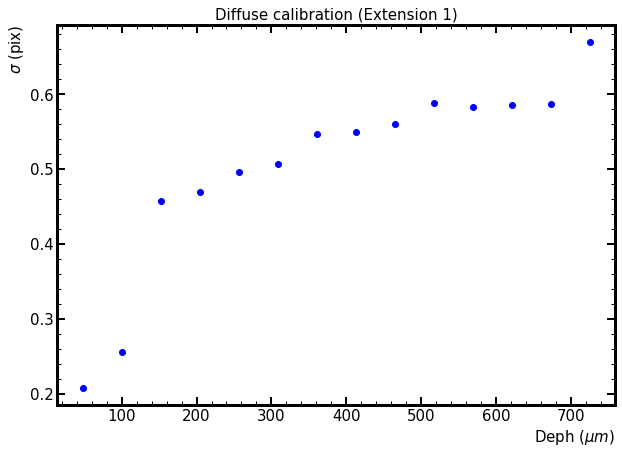

In [33]:
fig_2, axs_all_2 = plt.subplots(figsize = [10, 7])

axs_all_2.scatter(list_deep, list_sigmas[::-1], marker='o', color='b', label = 'Muon: 1')
# axs_all_2.scatter(list_all_deeps_2, list_all_sigmas_2, marker='v', color='r', label = 'Muon: 2')
# axs_all_2.scatter(list_all_deeps_3, list_all_sigmas_3, marker='^', color='g', label = 'Muon: 3')
# axs_all_2.scatter(list_all_deeps_4, list_all_sigmas_4, marker='<', color='m', label = 'Muon: 4')
# axs_all_2.scatter(list_all_deeps_5, list_all_sigmas_5, marker='>', color='orange', label = 'Muon: 5')


# axs_all_2.set_title('Diffuse calibration (Extension 1)', size = 15)#, y=0.92)}
# axs_all_2.set_title('Diffuse calibration (Extension 2)', size = 15)#, y=0.92)}
axs_all_2.set_title('Diffuse calibration (Extension 1)', size = 15)#, y=0.92)}
axs_all_2.set_ylabel(r'$\sigma$ (pix)')
axs_all_2.set_xlabel(r'Deph ($\mu m$)')
# axs_all_2.set_xlim(0, 725)
# axs_all_2.legend()
axs_all_2.grid

plt.show()
